In [1]:
from src.model.eegnet_variance import EEGNetMultiHeaded
from pytorch_lightning.loggers import CometLogger
from src.datamodule import DataModule, predictDataSet
from src.preprocessing import create_dataset
import pytorch_lightning as pl
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from src.preprocessing import *
from src.noise_addition import zero_signal, add_gaussian_noise
import copy
import random
import pickle

In [2]:
comet_logger = CometLogger(
    api_key="WSATCNWE43zphHslQCTsJKcgk",
    workspace="marwo22",  # Optional
    project_name="bachelors-project"  # Optional
)

CometLogger will be initialized in online mode


In [3]:
def add_guassian_noise_to_dataset(dataset, severity_index, low: int = 0, high: int = 308):
    if (severity_index == 0):
        return dataset

    length = len(dataset[0])
        # Add noise to 7.5%  * severityIndex of samples in the dataset. It can thus range from 5% to 50%
    episodes_to_corrupt = random.sample(range(0, length), int(0.1 * severity_index * length))
        # Add noise to the samples
    for episode in episodes_to_corrupt:
        channels_to_corrupt = int(64 / 10 * severity_index)
        dataset[0][episode] = add_gaussian_noise(dataset[0][episode], 2 * severity_index, channels_to_corrupt, low, high)

    return dataset

In [4]:
def add_zero_to_dataset(dataset, severity_index, low: int = 0, high: int = 308):
    if (severity_index == 0):
        return dataset
    
    length = len(dataset[0])
        # Add noise to 7.5%  * severityIndex of samples in the dataset. It can thus range from 5% to 50%
    episodes_to_corrupt = random.sample(range(0, length), int(0.1 * severity_index * length))
        # Add noise to the samples
    for episode in episodes_to_corrupt:
            # Can range from 5-50%
        channels_to_corrupt = int(64 / 10 * severity_index)
            # Zeroes the entire signal
        dataset[0][episode] = zero_signal(dataset[0][episode], channels_to_corrupt, low, high, 100)

    return dataset

Text(0.5, 0.98, 'The effect of strong localized noise on the first 5 channels')

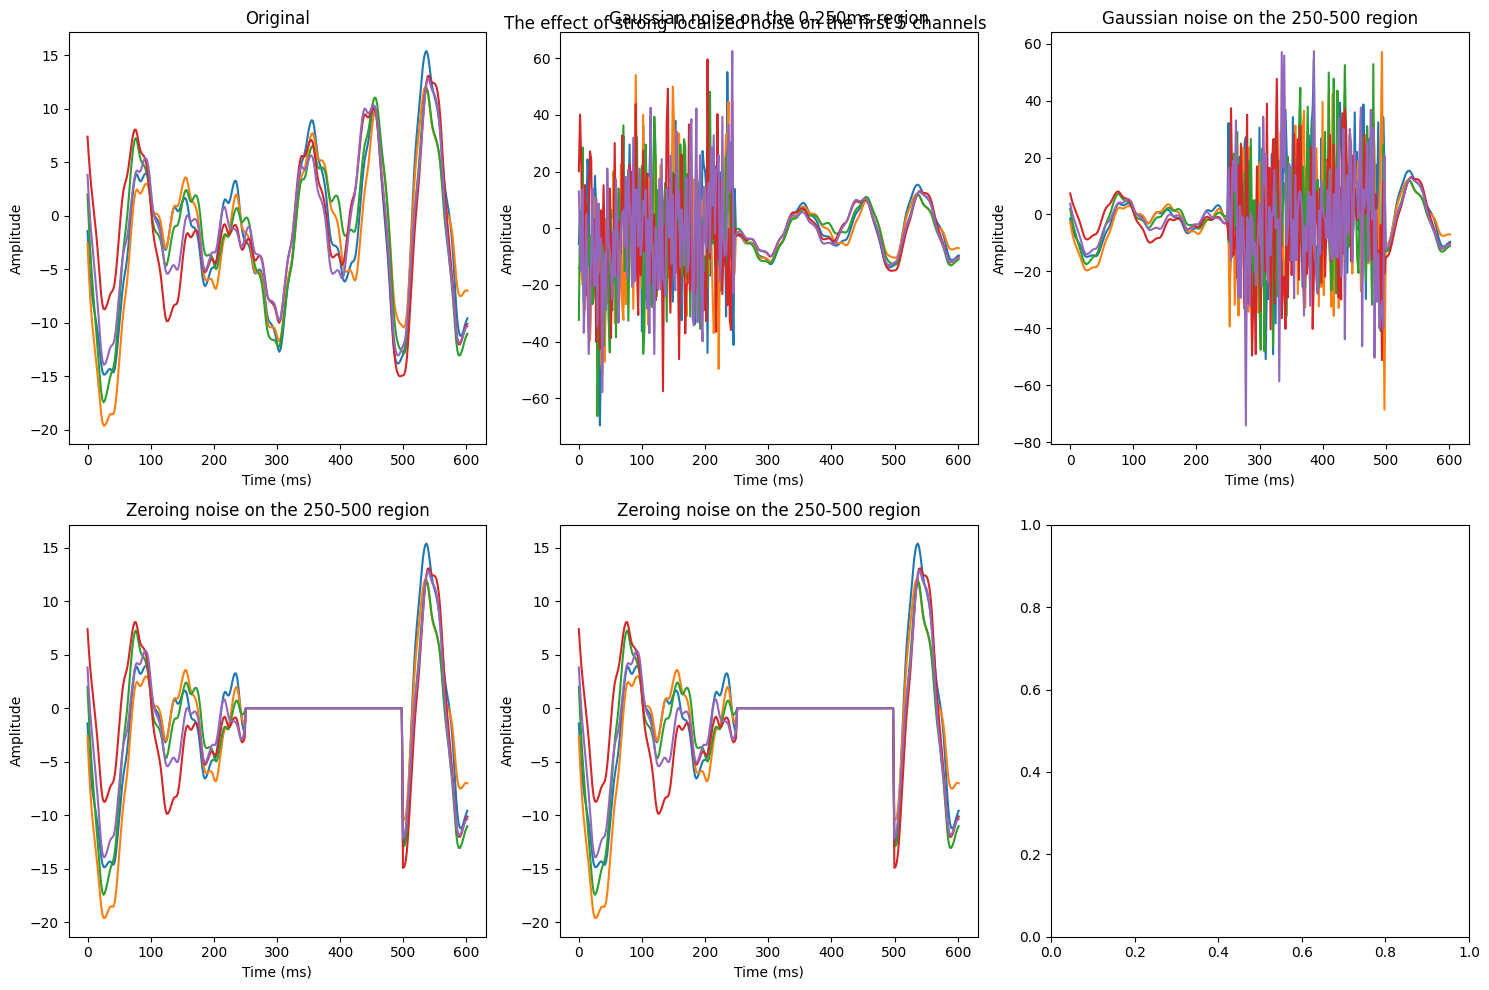

In [8]:
# Plot the first 5 channels of the original signal, localized noise on 0-250ms, and localized noise on 250-500ms

train, val, test = create_dataset('./src/pickle_df', 1)

train_copy = copy.deepcopy(train)
left_gaussian_noise = add_guassian_noise_to_dataset(train_copy, 10, low = 0, high = 127)

train_copy = copy.deepcopy(train)
right_gaussian_noise = add_guassian_noise_to_dataset(train_copy, 10, low = 128, high = 255)

train_copy = copy.deepcopy(train)
left_zeroing_noise = add_zero_to_dataset(train_copy, 10, low = 0, high = 127)

train_copy = copy.deepcopy(train)
right_zeroing_noise = add_zero_to_dataset(train_copy, 10, low = 128, high = 255)

duration = 308 / 512 * 1000
t = np.linspace(0, duration, 308)

figure, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0][0].plot(t, train[0][0][0], label='1')
axes[0][0].plot(t, train[0][0][1], label='2')
axes[0][0].plot(t, train[0][0][2], label="3")
axes[0][0].plot(t, train[0][0][3], label="4")
axes[0][0].plot(t, train[0][0][4], label="5")
axes[0][0].set_xlabel("Time (ms)")
axes[0][0].set_ylabel("Amplitude")
axes[0][0].set_title("Original")

axes[0][1].plot(t, left_gaussian_noise[0][0][0], label='1')
axes[0][1].plot(t, left_gaussian_noise[0][0][1], label='2')
axes[0][1].plot(t, left_gaussian_noise[0][0][2], label="3")
axes[0][1].plot(t, left_gaussian_noise[0][0][3], label="4")
axes[0][1].plot(t, left_gaussian_noise[0][0][4], label="5")
axes[0][1].set_xlabel("Time (ms)")
axes[0][1].set_ylabel("Amplitude")
axes[0][1].set_title("Gaussian noise on the 0-250ms region")

axes[0][2].plot(t, right_gaussian_noise[0][0][0], label='1')
axes[0][2].plot(t, right_gaussian_noise[0][0][1], label='2')
axes[0][2].plot(t, right_gaussian_noise[0][0][2], label="3")
axes[0][2].plot(t, right_gaussian_noise[0][0][3], label="4")
axes[0][2].plot(t, right_gaussian_noise[0][0][4], label="5")
axes[0][2].set_xlabel("Time (ms)")
axes[0][2].set_ylabel("Amplitude")
axes[0][2].set_title("Gaussian noise on the 250-500 region")

axes[1][0].plot(t, left_zeroing_noise[0][0][0], label='1')
axes[1][0].plot(t, left_zeroing_noise[0][0][1], label='2')
axes[1][0].plot(t, left_zeroing_noise[0][0][2], label="3")
axes[1][0].plot(t, left_zeroing_noise[0][0][3], label="4")
axes[1][0].plot(t, left_zeroing_noise[0][0][4], label="5")
axes[1][0].set_xlabel("Time (ms)")
axes[1][0].set_ylabel("Amplitude")
axes[1][0].set_title("Zeroing noise on the 250-500 region")

axes[1][1].plot(t, right_zeroing_noise[0][0][0], label='1')
axes[1][1].plot(t, right_zeroing_noise[0][0][1], label='2')
axes[1][1].plot(t, right_zeroing_noise[0][0][2], label="3")
axes[1][1].plot(t, right_zeroing_noise[0][0][3], label="4")
axes[1][1].plot(t, right_zeroing_noise[0][0][4], label="5")
axes[1][1].set_xlabel("Time (ms)")
axes[1][1].set_ylabel("Amplitude")
axes[1][1].set_title("Zeroing noise on the 250-500 region")

figure.tight_layout()
figure.suptitle("The effect of strong localized noise on the first 5 channels")
# Title and subtitle overlap, but its only for visualization

In [15]:
# Currently, I don't check the SHAP values for the highest influence area, but rather take the theoratical location of highest influence, which happens at around 250-500ms

# 0-250ms for low effect
# 250-500ms for high effect

# Tests for medium noise(5) on the low effect region, and medium noise on the high effect region

variances = [[] for _ in range(2)]
accuracies = [[] for _ in range(2)]

for j in range(6):  
    # Load in the datasets with the current participant as test set
    train, val, test = create_dataset('./src/pickle_df', j + 1)

    for i in range(2):
        # Take deep copies
        train_copy = copy.deepcopy(train)
        val_copy = copy.deepcopy(val)
        test_copy = copy.deepcopy(test)
        
        # Add noise to the deep copies. If i is 0, noise is added to the lower end, when it is 1, it is added to the higher end
        # For this experiment, the intensity value is 5, resulting in a 'medium' level of noise
        train_copy = add_guassian_noise_to_dataset(train_copy, 10, low = i * 128, high = (i + 1) * 128 - 1)
        val_copy = add_guassian_noise_to_dataset(val_copy, 10, low = i * 128, high = (i + 1) * 128 - 1)
        test_copy = add_guassian_noise_to_dataset(test_copy, 10, low = i * 128, high = (i + 1) * 128 - 1)

        dm = DataModule(train=train_copy, val=val_copy, test=test_copy, batch_size=16)

        model = EEGNetMultiHeaded(chunk_size=308,
                                num_electrodes=64,
                                dropout=0.5,
                                kernel_1=64,
                                kernel_2=16,
                                F1=8,
                                F2=16,
                                D=2,
                                num_classes=2)
        # Train for 25 epochs for this example
        # Final one for results wil run for 50 most likely
        trainer = pl.Trainer(
            max_epochs=25,
            logger=comet_logger
        )

        # Fit and test model
        trainer.fit(model, datamodule=dm)
        test_results = trainer.test(model, datamodule=dm)
        
        # Capture the testing variance and accuracy
        variances[i].append(test_results[0]['overall_var'])
        accuracies[i].append(test_results[0]['test_acc'])

        # Save them to a pkl file
        with open('results_pickled/localized_variances_gaussian.pkl', 'wb') as f:
            pickle.dump(variances, f)

        with open('results_pickled/localized_accuracies_gaussian.pkl', 'wb') as f:
            pickle.dump(accuracies, f)
    
    # Just to visualize progress easier, the output is very messy
    print("\n\n\n\n\nFinished" + str(j) + "\n\n\n\n\n")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\f30bbbec14d44331bfcdd612501731c7\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 431/431 [00:05<00:00, 72.64it/s, v_num=31c7]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 431/431 [00:05<00:00, 72.50it/s, v_num=31c7]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10775] : (6.345642566680908, 63.27985382080078)


COMET INFO:     val_loss [1677]    : (6.576570987701416, 55.45714569091797)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 93.33it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 29.69it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21185475742726595    │
│       incorrect_var       │    0.23808422733803908    │
│        overall_var        │    0.21479173004627228    │
│         test_acc          │    0.8726053833961487     │
│         test_loss         │    10.105890274047852     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21185475742726595
COMET INFO:     incorrect_var : 0.23808422733803908
COMET INFO:     overall_var   : 0.21479173004627228
COMET INFO:     test_acc      : 0.8726053833961487
COMET INFO:     test_loss     : 10.105890274047852
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: Tru

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7



Epoch 24: 100%|██████████| 431/431 [00:05<00:00, 81.24it/s, v_num=31c7]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 431/431 [00:05<00:00, 81.12it/s, v_num=31c7]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10775] : (6.689720153808594, 60.18556594848633)
COMET INFO:     val_loss [1677]    : (6.748647689819336, 45.56058883666992)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 90.27it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 29.72it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21254397825490515    │
│       incorrect_var       │    0.2382661679349994     │
│        overall_var        │    0.21622292697429657    │
│         test_acc          │    0.8524904251098633     │
│         test_loss         │     10.65849781036377     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21254397825490515
COMET INFO:     incorrect_var : 0.2382661679349994
COMET INFO:     overall_var   : 0.21622292697429657
COMET INFO:     test_acc      : 0.8524904251098633
COMET INFO:     test_loss     : 10.65849781036377
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages







Finished0







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\f30bbbec14d44331bfcdd612501731c7\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 79.07it/s, v_num=31c7]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 78.94it/s, v_num=31c7]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (1.3219183683395386, 49.55290222167969)
COMET INFO:     val_loss [1727]    : (1.89794921875, 51.90339660644531)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorc

Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 94.88it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 30.53it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22570747019736026    │
│       incorrect_var       │    0.23789329384054458    │
│        overall_var        │    0.22882653772830963    │
│         test_acc          │    0.7416666746139526     │
│         test_loss         │     13.59913444519043     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22570747019736026
COMET INFO:     incorrect_var : 0.23789329384054458
COMET INFO:     overall_var   : 0.22882653772830963
COMET INFO:     test_acc      : 0.7416666746139526
COMET INFO:     test_loss     : 13.59913444519043
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7



Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 80.70it/s, v_num=31c7]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 80.55it/s, v_num=31c7]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (-0.3937263488769531, 97700.890625)
COMET INFO:     val_loss [1727]    : (-1.814247488975525, 804.0677490234375)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning


COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 81.63it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 29.04it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.23050811559949633    │
│       incorrect_var       │    0.23250595023476547    │
│        overall_var        │    0.23101118206977844    │
│         test_acc          │    0.7759259343147278     │
│         test_loss         │    13.438958168029785     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.23050811559949633
COMET INFO:     incorrect_var : 0.23250595023476547
COMET INFO:     overall_var   : 0.23101118206977844
COMET INFO:     test_acc      : 0.7759259343147278
COMET INFO:     test_loss     : 13.438958168029785
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages







Finished1







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\f30bbbec14d44331bfcdd612501731c7\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 426/426 [00:05<00:00, 80.88it/s, v_num=31c7]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 426/426 [00:05<00:00, 80.76it/s, v_num=31c7]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10650] : (0.27271655201911926, 53.72625732421875)
COMET INFO:     val_loss [1727]    : (5.3913116455078125, 85.04096984863281)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\

Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 94.44it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 30.19it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.19708654344930984    │
│       incorrect_var       │    0.21769917391753066    │
│        overall_var        │    0.20254682004451752    │
│         test_acc          │    0.7220077514648438     │
│         test_loss         │    15.047225952148438     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.19708654344930984
COMET INFO:     incorrect_var : 0.21769917391753066
COMET INFO:     overall_var   : 0.20254682004451752
COMET INFO:     test_acc      : 0.7220077514648438
COMET INFO:     test_loss     : 15.047225952148438
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: Tru

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7



Epoch 24: 100%|██████████| 426/426 [00:05<00:00, 79.94it/s, v_num=31c7]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 426/426 [00:05<00:00, 79.82it/s, v_num=31c7]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------


COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10650] : (1.1362528800964355, 179.25717163085938)
COMET INFO:     val_loss [1727]    : (9.362531661987305, 74.97277069091797)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 95.90it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 30.04it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2381689029561058     │
│       incorrect_var       │    0.2424806355629151     │
│        overall_var        │    0.2396627515554428     │
│         test_acc          │    0.6438223719596863     │
│         test_loss         │    15.500378608703613     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2381689029561058
COMET INFO:     incorrect_var : 0.2424806355629151
COMET INFO:     overall_var   : 0.2396627515554428
COMET INFO:     test_acc      : 0.6438223719596863
COMET INFO:     test_loss     : 15.500378608703613
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages







Finished2







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\f30bbbec14d44331bfcdd612501731c7\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 427/427 [00:05<00:00, 84.79it/s, v_num=31c7]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 427/427 [00:05<00:00, 84.64it/s, v_num=31c7]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10675] : (4.504815101623535, 58.941612243652344)
COMET INFO:     val_loss [1677]    : (3.5801610946655273, 55.47674560546875)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 393 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages

Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 87.29it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 29.16it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.19758822826181902    │
│       incorrect_var       │     0.222240873346611     │
│        overall_var        │    0.20232290029525757    │
│         test_acc          │    0.8127376437187195     │
│         test_loss         │    11.157354354858398     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.19758822826181902
COMET INFO:     incorrect_var : 0.222240873346611
COMET INFO:     overall_var   : 0.20232290029525757
COMET INFO:     test_acc      : 0.8127376437187195
COMET INFO:     test_loss     : 11.157354354858398
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True
T

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7



Epoch 24: 100%|██████████| 427/427 [00:05<00:00, 81.79it/s, v_num=31c7]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 427/427 [00:05<00:00, 81.65it/s, v_num=31c7]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10675] : (9.071123123168945, 13868.439453125)
COMET INFO:     val_loss [1677]    : (3.8217310905456543, 41.3277587890625)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 391 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 95.34it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 29.49it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2475900191031818     │
│       incorrect_var       │    0.24757826842789882    │
│        overall_var        │    0.24758313596248627    │
│         test_acc          │    0.7832699418067932     │
│         test_loss         │    15.138609886169434     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2475900191031818
COMET INFO:     incorrect_var : 0.24757826842789882
COMET INFO:     overall_var   : 0.24758313596248627
COMET INFO:     test_acc      : 0.7832699418067932
COMET INFO:     test_loss     : 15.138609886169434
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages







Finished3







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\f30bbbec14d44331bfcdd612501731c7\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 425/425 [00:05<00:00, 82.33it/s, v_num=31c7]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:05<00:00, 82.20it/s, v_num=31c7]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (4.290717124938965, 57.981048583984375)
COMET INFO:     val_loss [1652]    : (3.97719144821167, 45.99372100830078)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 152 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 93.60it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 31.40it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.1947050180252872     │
│       incorrect_var       │    0.22659818673745186    │
│        overall_var        │    0.19972288608551025    │
│         test_acc          │     0.854853093624115     │
│         test_loss         │     9.690400123596191     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.1947050180252872
COMET INFO:     incorrect_var : 0.22659818673745186
COMET INFO:     overall_var   : 0.19972288608551025
COMET INFO:     test_acc      : 0.854853093624115
COMET INFO:     test_loss     : 9.690400123596191
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True
TP

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7



Epoch 24: 100%|██████████| 425/425 [00:05<00:00, 81.75it/s, v_num=31c7]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:05<00:00, 81.63it/s, v_num=31c7]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (4.806758403778076, 48.41495132446289)
COMET INFO:     val_loss [1652]    : (5.044988632202148, 48.54501724243164)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 151 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 83.73it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 30.56it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21411460876931696    │
│       incorrect_var       │    0.2307688446715474     │
│        overall_var        │    0.21758313477039337    │
│         test_acc          │    0.8094390034675598     │
│         test_loss         │      11.986083984375      │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21411460876931696
COMET INFO:     incorrect_var : 0.2307688446715474
COMET INFO:     overall_var   : 0.21758313477039337
COMET INFO:     test_acc      : 0.8094390034675598
COMET INFO:     test_loss     : 11.986083984375
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages







Finished4







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\f30bbbec14d44331bfcdd612501731c7\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 421/421 [00:05<00:00, 81.14it/s, v_num=31c7]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 421/421 [00:05<00:00, 80.97it/s, v_num=31c7]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------


COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10525] : (1.5545403957366943, 44.91487121582031)
COMET INFO:     val_loss [1677]    : (4.24448299407959, 51.405113220214844)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the n

Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 95.48it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 31.25it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.1835882595346983     │
│       incorrect_var       │    0.21155251511369763    │
│        overall_var        │    0.1920861303806305     │
│         test_acc          │    0.7059891223907471     │
│         test_loss         │     14.82646656036377     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.1835882595346983
COMET INFO:     incorrect_var : 0.21155251511369763
COMET INFO:     overall_var   : 0.1920861303806305
COMET INFO:     test_acc      : 0.7059891223907471
COMET INFO:     test_loss     : 14.82646656036377
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True
T

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7



Epoch 24: 100%|██████████| 421/421 [00:05<00:00, 81.31it/s, v_num=31c7]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 421/421 [00:05<00:00, 81.17it/s, v_num=31c7]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10525] : (0.7996816635131836, 54.38218688964844)


COMET INFO:     val_loss [1677]    : (5.076940536499023, 45.80918502807617)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 82.75it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 28.78it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.20681814394818945    │
│       incorrect_var       │    0.22260298749624977    │
│        overall_var        │    0.21155452728271484    │
│         test_acc          │    0.6996369957923889     │
│         test_loss         │    14.771485328674316     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/f30bbbec14d44331bfcdd612501731c7
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.20681814394818945
COMET INFO:     incorrect_var : 0.22260298749624977
COMET INFO:     overall_var   : 0.21155452728271484
COMET INFO:     test_acc      : 0.6996369957923889
COMET INFO:     test_loss     : 14.771485328674316
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages







Finished5







In [6]:
# Currently, I don't check the SHAP values for the highest influence area, but rather take the theoratical location of highest influence, which happens at around 250-500ms

# 0-250ms for low effect
# 250-500ms for high effect

# Tests for medium noise(5) on the low effect region, and medium noise on the high effect region

variances = [[] for _ in range(2)]
accuracies = [[] for _ in range(2)]

for j in range(6):  
    # Load in the datasets with the current participant as test set
    train, val, test = create_dataset('./src/pickle_df', j + 1)

    for i in range(2):
        # Take deep copies
        train_copy = copy.deepcopy(train)
        val_copy = copy.deepcopy(val)
        test_copy = copy.deepcopy(test)
        
        # Add noise to the deep copies. If i is 0, noise is added to the lower end, when it is 1, it is added to the higher end
        # For this experiment, the intensity value is 5, resulting in a 'medium' level of noise
        train_copy = add_zero_to_dataset(train_copy, 10, low = i * 128, high = (i + 1) * 128 - 1)
        val_copy = add_zero_to_dataset(val_copy, 10, low = i * 128, high = (i + 1) * 128 - 1)
        test_copy = add_zero_to_dataset(test_copy, 10, low = i * 128, high = (i + 1) * 128 - 1)

        dm = DataModule(train=train_copy, val=val_copy, test=test_copy, batch_size=16)

        model = EEGNetMultiHeaded(chunk_size=308,
                                num_electrodes=64,
                                dropout=0.5,
                                kernel_1=64,
                                kernel_2=16,
                                F1=8,
                                F2=16,
                                D=2,
                                num_classes=2)
        # Train for 25 epochs for this example
        # Final one for results wil run for 50 most likely
        trainer = pl.Trainer(
            max_epochs=25,
            logger=comet_logger
        )

        # Fit and test model
        trainer.fit(model, datamodule=dm)
        test_results = trainer.test(model, datamodule=dm)
        
        # Capture the testing variance and accuracy
        variances[i].append(test_results[0]['overall_var'])
        accuracies[i].append(test_results[0]['test_acc'])

        # Save them to a pkl file
        with open('results_pickled/localized_variances_zeroed.pkl', 'wb') as f:
            pickle.dump(variances, f)

        with open('results_pickled/localized_accuracies_zeroed.pkl', 'wb') as f:
            pickle.dump(accuracies, f)
    
    # Just to visualize progress easier, the output is very messy
    print("\n\n\n\n\nFinished" + str(j) + "\n\n\n\n\n")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 85.53it/s, v_num=dda0] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 85.40it/s, v_num=dda0]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------


COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10725] : (6.328814506530762, 58.664085388183594)
COMET INFO:     val_loss [1702]    : (4.958106994628906, 41.422645568847656)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (1.58 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for metadata to finish uploading (timeout is 3600 seconds)


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 95.19it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 30.19it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21191995646146125    │
│       incorrect_var       │     0.234740085958761     │
│        overall_var        │    0.21500568091869354    │
│         test_acc          │    0.8649425506591797     │
│         test_loss         │    10.553293228149414     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21191995646146125
COMET INFO:     incorrect_var : 0.234740085958761
COMET INFO:     overall_var   : 0.21500568091869354
COMET INFO:     test_acc      : 0.8649425506591797
COMET INFO:     test_loss     : 10.553293228149414
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True
T

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0



Epoch 24: 100%|██████████| 429/429 [00:04<00:00, 88.36it/s, v_num=dda0]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 429/429 [00:04<00:00, 88.21it/s, v_num=dda0]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10725] : (8.35338306427002, 47.97103500366211)
COMET INFO:     val_loss [1702]    : (9.551149368286133, 90.79100036621094)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 94.93it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 30.24it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22661477332054616    │
│       incorrect_var       │    0.23903851324934988    │
│        overall_var        │    0.22964029014110565    │
│         test_acc          │    0.7567049860954285     │
│         test_loss         │    13.283852577209473     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22661477332054616
COMET INFO:     incorrect_var : 0.23903851324934988
COMET INFO:     overall_var   : 0.22964029014110565
COMET INFO:     test_acc      : 0.7567049860954285
COMET INFO:     test_loss     : 13.283852577209473
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages







Finished0







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\4400bb6d41094b9c9765053ec6a3dda0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 430/430 [00:05<00:00, 85.16it/s, v_num=dda0]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 430/430 [00:05<00:00, 84.99it/s, v_num=dda0]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10750] : (1.8424886465072632, 48.926597595214844)
COMET INFO:     val_loss [1702]    : (1.2786184549331665, 47.53581619262695)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning


COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 20 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 86.40it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 29.84it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.20959362668844816    │
│       incorrect_var       │    0.23345671268235446    │
│        overall_var        │    0.21454693377017975    │
│         test_acc          │    0.7972221970558167     │
│         test_loss         │     11.86880111694336     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.20959362668844816
COMET INFO:     incorrect_var : 0.23345671268235446
COMET INFO:     overall_var   : 0.21454693377017975
COMET INFO:     test_acc      : 0.7972221970558167
COMET INFO:     test_loss     : 11.86880111694336
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0



Epoch 24: 100%|██████████| 430/430 [00:04<00:00, 88.61it/s, v_num=dda0]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 430/430 [00:04<00:00, 88.43it/s, v_num=dda0]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:


COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10750] : (4.169719696044922, 59.91621398925781)
COMET INFO:     val_loss [1702]    : (3.5823397636413574, 52.24850082397461)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 19 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 98.10it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 31.27it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22883393601233534    │
│       incorrect_var       │    0.2361423149594076     │
│        overall_var        │    0.23134543001651764    │
│         test_acc          │    0.6518518328666687     │
│         test_loss         │    15.273833274841309     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22883393601233534
COMET INFO:     incorrect_var : 0.2361423149594076
COMET INFO:     overall_var   : 0.23134543001651764
COMET INFO:     test_acc      : 0.6518518328666687
COMET INFO:     test_loss     : 15.273833274841309
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages







Finished1







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\4400bb6d41094b9c9765053ec6a3dda0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 87.71it/s, v_num=dda0]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 87.58it/s, v_num=dda0]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (0.2094569206237793, 54.237083435058594)
COMET INFO:     val_loss [1752]    : (5.5666399002075195, 49.3948974609375)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 99.49it/s] 

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 30.57it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2168909866697526     │
│       incorrect_var       │    0.22732348574404554    │
│        overall_var        │    0.22091130912303925    │
│         test_acc          │    0.6467181444168091     │
│         test_loss         │    15.862689018249512     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2168909866697526
COMET INFO:     incorrect_var : 0.22732348574404554
COMET INFO:     overall_var   : 0.22091130912303925
COMET INFO:     test_acc      : 0.6467181444168091
COMET INFO:     test_loss     : 15.862689018249512
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0



Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 85.78it/s, v_num=dda0]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:04<00:00, 85.65it/s, v_num=dda0]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (0.6473603248596191, 56.1803092956543)
COMET INFO:     val_loss [1752]    : (6.663998603820801, 57.49367904663086)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 82.59it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 28.12it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22947506959972544    │
│       incorrect_var       │    0.23359420654058896    │
│        overall_var        │    0.23109857738018036    │
│         test_acc          │    0.6708494424819946     │
│         test_loss         │    15.254277229309082     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22947506959972544
COMET INFO:     incorrect_var : 0.23359420654058896
COMET INFO:     overall_var   : 0.23109857738018036
COMET INFO:     test_acc      : 0.6708494424819946
COMET INFO:     test_loss     : 15.254277229309082
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages







Finished2







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\4400bb6d41094b9c9765053ec6a3dda0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 85.39it/s, v_num=dda0]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 85.25it/s, v_num=dda0]

COMET INFO: ---------------------------------------------------------------------------------------


COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10725] : (4.330348968505859, 67.99537658691406)
COMET INFO:     val_loss [1702]    : (4.877007007598877, 47.99393844604492)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_d

Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 88.94it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 29.23it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.18689259905017702    │
│       incorrect_var       │    0.21816688126143552    │
│        overall_var        │    0.19262336194515228    │
│         test_acc          │    0.8108364939689636     │
│         test_loss         │    10.981253623962402     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.18689259905017702
COMET INFO:     incorrect_var : 0.21816688126143552
COMET INFO:     overall_var   : 0.19262336194515228
COMET INFO:     test_acc      : 0.8108364939689636
COMET INFO:     test_loss     : 10.981253623962402
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: Tru

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0



Epoch 24: 100%|██████████| 429/429 [00:04<00:00, 85.87it/s, v_num=dda0]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 85.73it/s, v_num=dda0]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10725] : (6.725039005279541, 60.69839096069336)
COMET INFO:     val_loss [1702]    : (7.036070823669434, 58.14885711669922)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 93.99it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 29.96it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22909384861482793    │
│       incorrect_var       │    0.23808747888501844    │
│        overall_var        │    0.23110419511795044    │
│         test_acc          │    0.7680608630180359     │
│         test_loss         │    13.485173225402832     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22909384861482793
COMET INFO:     incorrect_var : 0.23808747888501844
COMET INFO:     overall_var   : 0.23110419511795044
COMET INFO:     test_acc      : 0.7680608630180359
COMET INFO:     test_loss     : 13.485173225402832
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages







Finished3







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\4400bb6d41094b9c9765053ec6a3dda0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 419/419 [00:04<00:00, 85.74it/s, v_num=dda0]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 419/419 [00:04<00:00, 85.60it/s, v_num=dda0]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10475] : (5.70957088470459, 45.5984001159668)
COMET INFO:     val_loss [1727]    : (5.525437355041504, 49.87607955932617)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 52 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 90.04it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 31.06it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.20539064560927275    │
│       incorrect_var       │    0.2282947712831008     │
│        overall_var        │    0.20881269872188568    │
│         test_acc          │    0.8432769179344177     │
│         test_loss         │    10.795975685119629     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.20539064560927275
COMET INFO:     incorrect_var : 0.2282947712831008
COMET INFO:     overall_var   : 0.20881269872188568
COMET INFO:     test_acc      : 0.8432769179344177
COMET INFO:     test_loss     : 10.795975685119629
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0



Epoch 24: 100%|██████████| 419/419 [00:05<00:00, 81.75it/s, v_num=dda0]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 419/419 [00:05<00:00, 81.61it/s, v_num=dda0]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1


COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10475] : (8.00925350189209, 55.034698486328125)
COMET INFO:     val_loss [1727]    : (6.990880966186523, 48.15298080444336)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 51 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 93.66it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 31.57it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2270827156316893     │
│       incorrect_var       │    0.23643696170764847    │
│        overall_var        │    0.22934550046920776    │
│         test_acc          │    0.7640249133110046     │
│         test_loss         │    13.419055938720703     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2270827156316893
COMET INFO:     incorrect_var : 0.23643696170764847
COMET INFO:     overall_var   : 0.22934550046920776
COMET INFO:     test_acc      : 0.7640249133110046
COMET INFO:     test_loss     : 13.419055938720703
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages







Finished4







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\4400bb6d41094b9c9765053ec6a3dda0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 421/421 [00:05<00:00, 83.35it/s, v_num=dda0]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 421/421 [00:05<00:00, 83.20it/s, v_num=dda0]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10525] : (0.5630235075950623, 55.38106155395508)
COMET INFO:     val_loss [1727]    : (3.6795740127563477, 50.53892135620117)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 185 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages

Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 93.92it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 31.09it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │     0.221703685603136     │
│       incorrect_var       │    0.22655856177244618    │
│        overall_var        │    0.22361522912979126    │
│         test_acc          │    0.6034482717514038     │
│         test_loss         │    17.277015686035156     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.221703685603136
COMET INFO:     incorrect_var : 0.22655856177244618
COMET INFO:     overall_var   : 0.22361522912979126
COMET INFO:     test_acc      : 0.6034482717514038
COMET INFO:     test_loss     : 17.277015686035156
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True
T

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0



Epoch 24: 100%|██████████| 421/421 [00:04<00:00, 85.14it/s, v_num=dda0]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 421/421 [00:04<00:00, 85.01it/s, v_num=dda0]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10525] : (0.7344603538513184, 68.6884994506836)
COMET INFO:     val_loss [1727]    : (8.040889739990234, 49.551876068115234)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 184 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 78.76it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 29.29it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │     0.215826078729661     │
│       incorrect_var       │    0.23351373962137853    │
│        overall_var        │    0.22080807387828827    │
│         test_acc          │    0.7041742205619812     │
│         test_loss         │    13.714210510253906     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/4400bb6d41094b9c9765053ec6a3dda0
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.215826078729661
COMET INFO:     incorrect_var : 0.23351373962137853
COMET INFO:     overall_var   : 0.22080807387828827
COMET INFO:     test_acc      : 0.7041742205619812
COMET INFO:     test_loss     : 13.714210510253906
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages







Finished5







Text(0.5, 1.0, 'Effect of zeroing on accuracy')

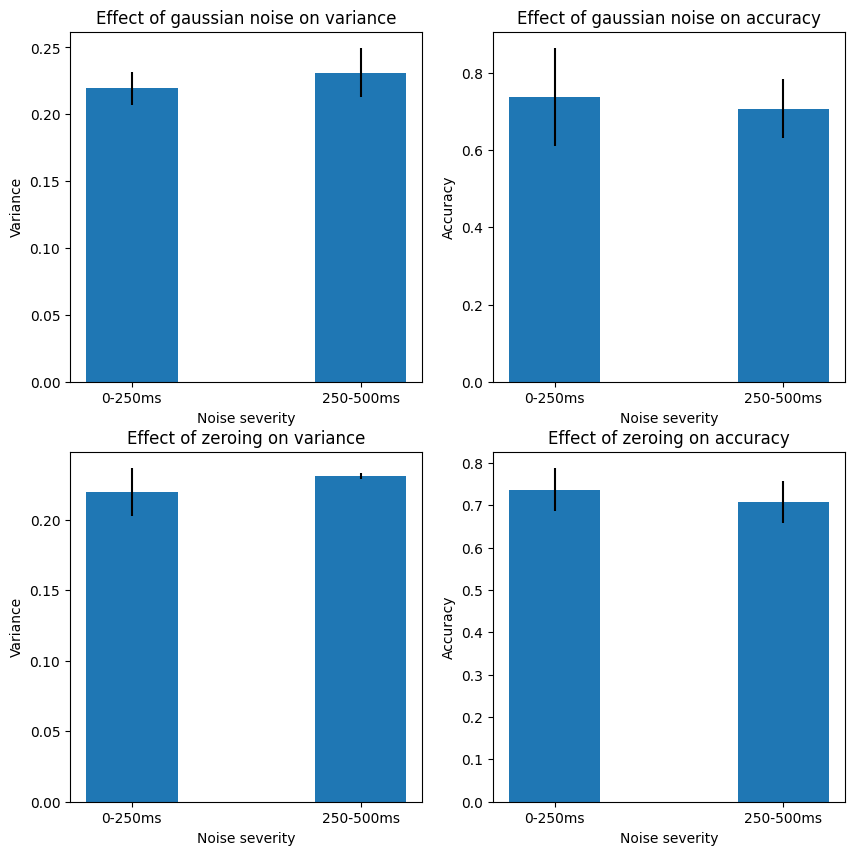

In [8]:
# Load in the .pkl files
with open('results_pickled/localized_accuracies_gaussian.pkl', 'rb') as f:
    accuracies_gaussian = pickle.load(f)

with open('results_pickled/localized_variances_gaussian.pkl', 'rb') as f:
    variances_gaussian = pickle.load(f)

with open('results_pickled/localized_accuracies_zeroed.pkl', 'rb') as f:
    accuracies_zeroed = pickle.load(f)

with open('results_pickled/localized_variances_zeroed.pkl', 'rb') as f:
    variances_zeroed = pickle.load(f)

standard_deviation_variances_gaussian = []
standard_deviation_accuracies_gaussian = []
standard_deviation_variances_zeroed = []
standard_deviation_accuracies_zeroed = []

# Take the mean of the accuracies and variances
for i in range(2):
    standard_deviation_variances_gaussian.append(np.asarray(variances_gaussian[i]).std())
    standard_deviation_accuracies_gaussian.append(np.asarray(accuracies_gaussian[i]).std())
    standard_deviation_variances_zeroed.append(np.asarray(variances_zeroed[i]).std())
    standard_deviation_accuracies_zeroed.append(np.asarray(accuracies_zeroed[i]).std())
    variances_gaussian[i] = np.asarray(variances[i]).mean()
    accuracies_gaussian[i] = np.asarray(accuracies[i]).mean()
    variances_zeroed[i] = np.asarray(variances[i]).mean()
    accuracies_zeroed[i] = np.asarray(accuracies[i]).mean()

# Create a barplot of the variances and accuracies
figure, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0][0].bar(["0-250ms", "250-500ms"], variances_gaussian, yerr=standard_deviation_variances_gaussian, width = 0.4)
axes[0][0].set_xlabel("Noise severity")
axes[0][0].set_ylabel("Variance")
axes[0][0].set_title("Effect of gaussian noise on variance")
axes[0][1].bar(["0-250ms", "250-500ms"], accuracies_gaussian, yerr=standard_deviation_accuracies_gaussian, width = 0.4)
axes[0][1].set_xlabel("Noise severity")
axes[0][1].set_ylabel("Accuracy")
axes[0][1].set_title("Effect of gaussian noise on accuracy")

axes[1][0].bar(["0-250ms", "250-500ms"], variances_zeroed, yerr=standard_deviation_variances_zeroed, width = 0.4)
axes[1][0].set_xlabel("Noise severity")
axes[1][0].set_ylabel("Variance")
axes[1][0].set_title("Effect of zeroing on variance")
axes[1][1].bar(["0-250ms", "250-500ms"], accuracies_zeroed, yerr=standard_deviation_accuracies_zeroed, width = 0.4)
axes[1][1].set_xlabel("Noise severity")
axes[1][1].set_ylabel("Accuracy")
axes[1][1].set_title("Effect of zeroing on accuracy")

# As can be seen, there is practically no difference between the two noise locations
# Variance and accuracy are almost identical